# Bernstein-Vazirani Benchmark Program - Qiskit

In [1]:
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sys.path[1:1] = [ "_common", "_common/qiskit" ]
sys.path[1:1] = [ "../../_common", "../../_common/qiskit" ]
import execute as ex
import metrics as metrics

# Benchmark Name

In [2]:
benchmark_name = "Bernstein-Vazirani"

np.random.seed(0)

verbose = False

# Variable for number of resets to perform after mid circuit measurements
num_resets = 1

# saved circuits for display
QC_ = None
Uf_ = None

# Circuit Definition

In [3]:
def create_oracle(num_qubits, input_size, secret_int):
    # Initialize first n qubits and single ancilla qubit
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr, name=f"Uf")

    # perform CX for each qubit that matches a bit in secret string
    s = ('{0:0' + str(input_size) + 'b}').format(secret_int)
    for i_qubit in range(input_size):
        if s[input_size - 1 - i_qubit] == '1':
            qc.cx(qr[i_qubit], qr[input_size])
    return qc

In [4]:
def BersteinVazirani (num_qubits, secret_int, method = 1):
    
    # size of input is one less than available qubits
    input_size = num_qubits - 1

    if method == 1:
        # allocate qubits
        qr = QuantumRegister(num_qubits); cr = ClassicalRegister(input_size);
        qc = QuantumCircuit(qr, cr, name=f"bv({method})-{num_qubits}-{secret_int}")

        # put ancilla in |1> state
        qc.x(qr[input_size])

        # start with Hadamard on all qubits, including ancilla
        for i_qubit in range(num_qubits):
             qc.h(qr[i_qubit])

        qc.barrier()

        #generate Uf oracle
        Uf = create_oracle(num_qubits, input_size, secret_int)
        qc.append(Uf,qr)

        qc.barrier()

        # start with Hadamard on all qubits, including ancilla
        for i_qubit in range(num_qubits):
             qc.h(qr[i_qubit])

        # uncompute ancilla qubit, not necessary for algorithm
        qc.x(qr[input_size])

        qc.barrier()

        # measure all data qubits
        for i in range(input_size):
            qc.measure(i, i)

        global Uf_
        if Uf_ == None or num_qubits <= 6:
            if num_qubits < 9: Uf_ = Uf

    elif method == 2:
        # allocate qubits
        qr = QuantumRegister(2); cr = ClassicalRegister(input_size); qc = QuantumCircuit(qr, cr, name="main")

        # put ancilla in |-> state
        qc.x(qr[1])
        qc.h(qr[1])

        qc.barrier()

        # perform CX for each qubit that matches a bit in secret string
        s = ('{0:0' + str(input_size) + 'b}').format(secret_int)
        for i in range(input_size):
            if s[input_size - 1 - i] == '1':
                qc.h(qr[0])
                qc.cx(qr[0], qr[1])
                qc.h(qr[0])
            qc.measure(qr[0], cr[i])

            # Perform num_resets reset operations
            qc.reset([0]*num_resets)

    # save smaller circuit example for display
    global QC_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc

    # return a handle on the circuit
    return qc


# Result Data Analysis

In [5]:
# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, secret_int, num_shots):
    
    # size of input is one less than available qubits
    input_size = num_qubits - 1
    
    # obtain counts from the result object
    counts = result.get_counts(qc)
    if verbose: print(f"For secret int {secret_int} measured: {counts}")
    
    # create the key that is expected to have all the measurements (for this circuit)
    key = format(secret_int, f"0{input_size}b")
    
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)
        
    return counts, fidelity

# Benchmark Loop

In [6]:
# Execute program with default parameters
def run (min_qubits=3, max_qubits=6, skip_qubits=1, max_circuits=3, num_shots=100,
        backend_id='qasm_simulator', method = 1, provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")

    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Variable for new qubit group ordering if using mid_circuit measurements
    mid_circuit_qubit_group = []

    # If using mid_circuit measurements, set transform qubit group to true
    transform_qubit_group = True if method ==2 else False
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    # for noiseless simulation, set noise model to be None
    # ex.set_noise_model(None)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
    
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2**(input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(input_size) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(input_size), num_circuits, False)

        # loop over limited # of secret strings for this
        for s_int in s_range:
            # If mid circuit, then add 2 to new qubit group since the circuit only uses 2 qubits
            if method == 2:
                mid_circuit_qubit_group.append(2)

            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = BersteinVazirani(num_qubits, s_int, method)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)

            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, s_int, shots=num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
        
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method == 1: print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit",
                         transform_qubit_group = transform_qubit_group, new_qubit_group = mid_circuit_qubit_group)

Bernstein-Vazirani (1) Benchmark Program - Qiskit
... execution starting at Nov 08, 2023 06:28:54 UTC
************
Executing [3] circuits with num_qubits = 3
************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 6, 0.141
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 6, 0.116, 1.333
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.288, 0.01 secs
Average Transpiling, Validating, Running Times for group 3 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.0, 0.0

************
Executing [3] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 6, 0.061
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 6, 0.044, 0.667
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.0, 0.649, 0.02 secs
Average Transpiling, Validati

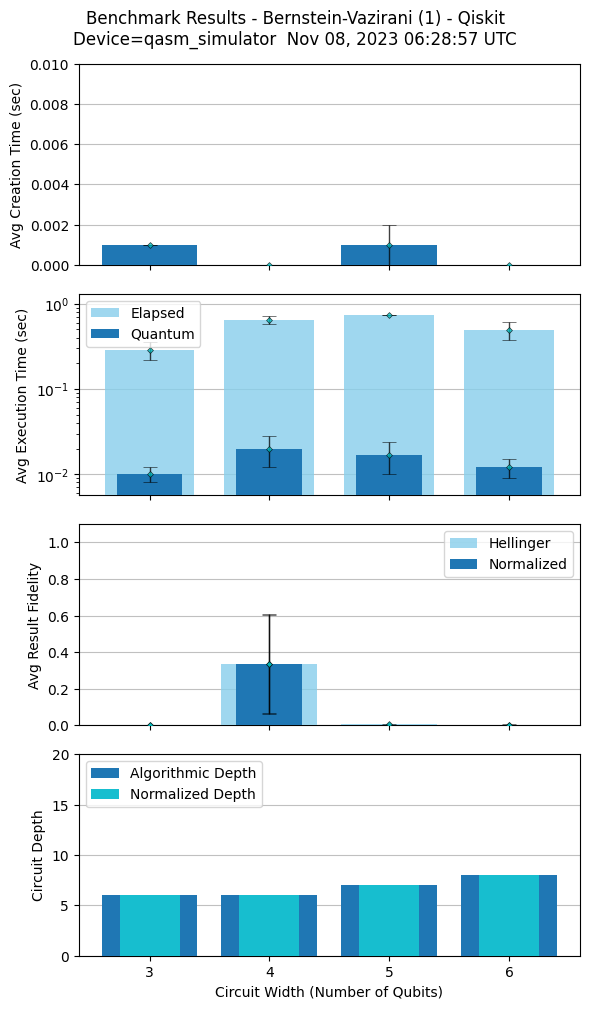

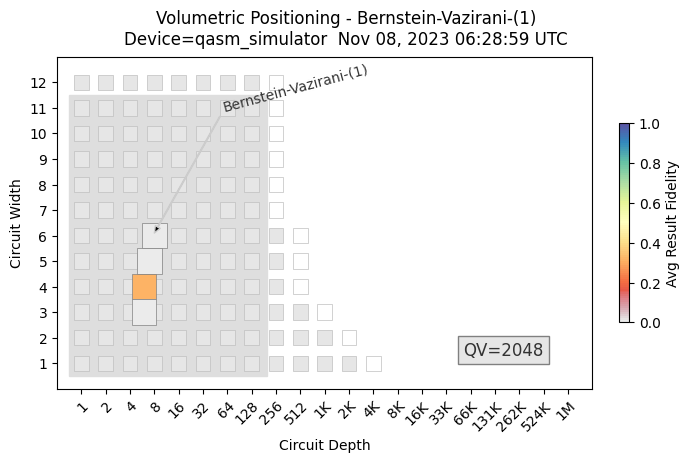

In [7]:
if __name__ == '__main__': run()

# statevector_simulator

Bernstein-Vazirani (1) Benchmark Program - Qiskit
... execution starting at Nov 08, 2023 06:29:00 UTC
************
Executing [3] circuits with num_qubits = 3
************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 6, 0.141
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 6, 0.116, 1.333
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.002, 0.355, 0.01 secs
Average Transpiling, Validating, Running Times for group 3 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.007, 0.0

************
Executing [3] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 7, 0.163
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 7, 0.123, 2.0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.001, 0.683, 0.014 secs
Average Transpiling, Valid

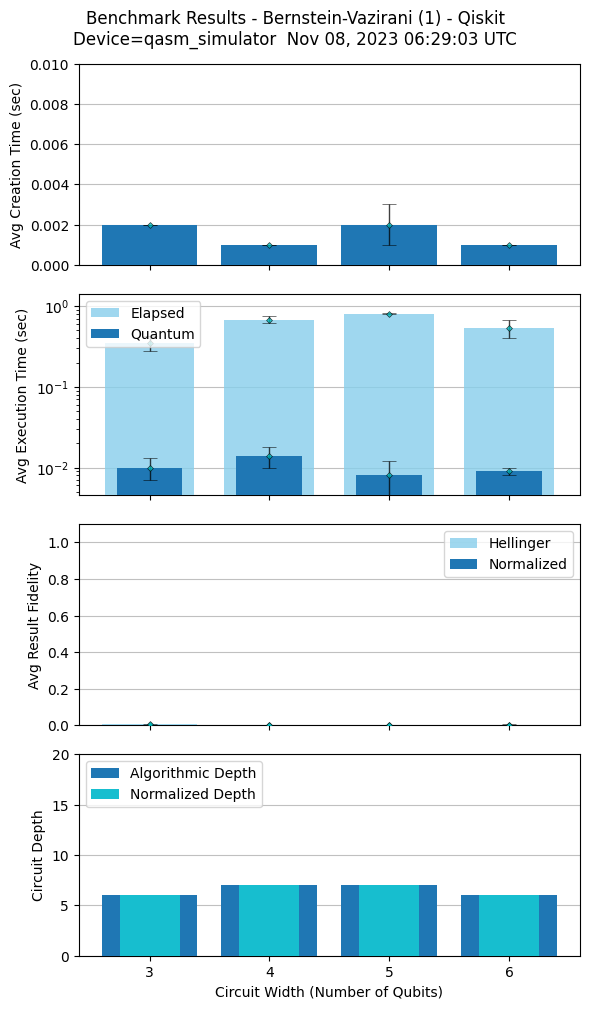

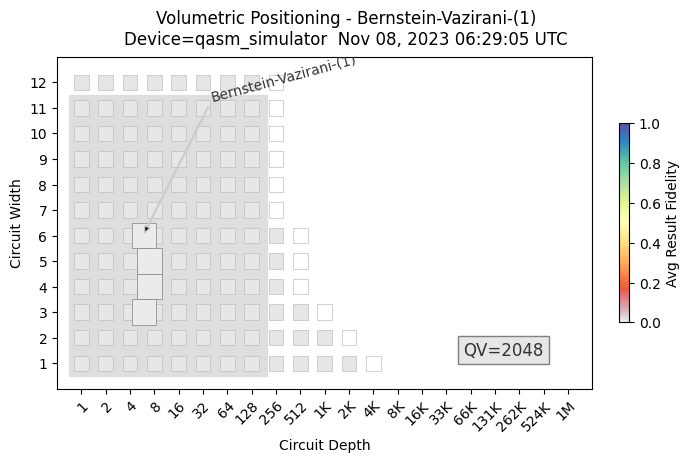

In [8]:
# Execute program with default parameters
def run (min_qubits=3, max_qubits=6, skip_qubits=1, max_circuits=3, num_shots=100,
        backend_id='qasm_simulator', method = 1, provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")

    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Variable for new qubit group ordering if using mid_circuit measurements
    mid_circuit_qubit_group = []

    # If using mid_circuit measurements, set transform qubit group to true
    transform_qubit_group = True if method ==2 else False
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    # for noiseless simulation, set noise model to be None
    # ex.set_noise_model(None)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
    
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2**(input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(input_size) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(input_size), num_circuits, False)

        # loop over limited # of secret strings for this
        for s_int in s_range:
            # If mid circuit, then add 2 to new qubit group since the circuit only uses 2 qubits
            if method == 2:
                mid_circuit_qubit_group.append(2)

            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = BersteinVazirani(num_qubits, s_int, method)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)

            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, s_int, shots=num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
        
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method == 1: print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit",
                         transform_qubit_group = transform_qubit_group, new_qubit_group = mid_circuit_qubit_group)
if __name__ == '__main__': run()

# unitary_simulator

Bernstein-Vazirani (1) Benchmark Program - Qiskit
... execution starting at Nov 08, 2023 06:30:26 UTC
************
Executing [3] circuits with num_qubits = 3
************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 6, 0.141
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 6, 0.116, 1.333
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.302, 0.004 secs
Average Transpiling, Validating, Running Times for group 3 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.003, 0.0

************
Executing [3] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 7, 0.163
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 7, 0.123, 2.0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.0, 0.667, 0.007 secs
Average Transpiling, Valida

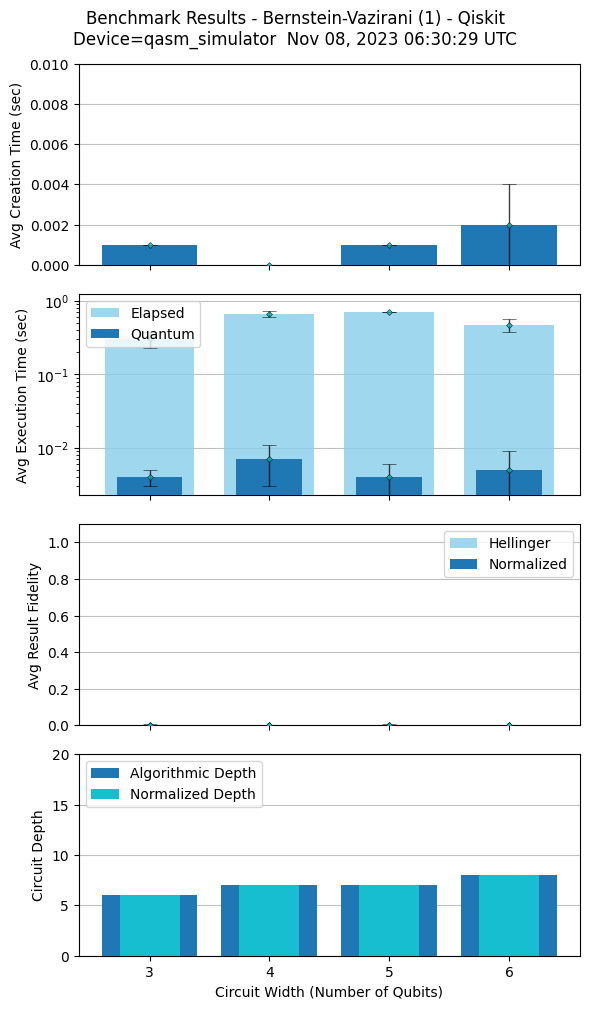

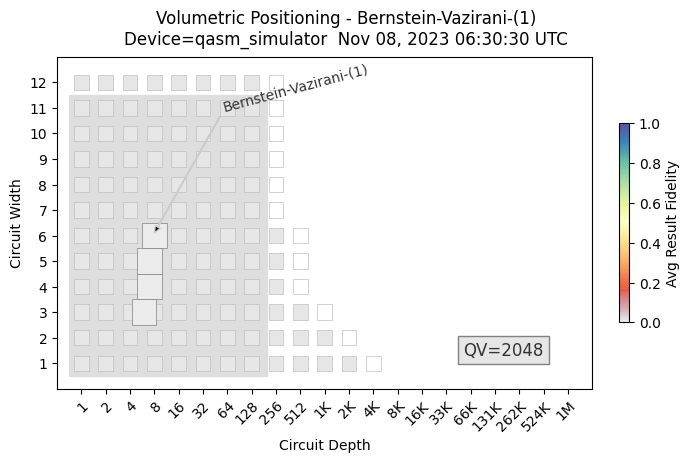

In [9]:
# Execute program with default parameters
def run (min_qubits=3, max_qubits=6, skip_qubits=1, max_circuits=3, num_shots=100,
        backend_id='qasm_simulator', method = 1, provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")

    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Variable for new qubit group ordering if using mid_circuit measurements
    mid_circuit_qubit_group = []

    # If using mid_circuit measurements, set transform qubit group to true
    transform_qubit_group = True if method ==2 else False
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    # for noiseless simulation, set noise model to be None
    # ex.set_noise_model(None)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
    
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2**(input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(input_size) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(input_size), num_circuits, False)

        # loop over limited # of secret strings for this
        for s_int in s_range:
            # If mid circuit, then add 2 to new qubit group since the circuit only uses 2 qubits
            if method == 2:
                mid_circuit_qubit_group.append(2)

            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = BersteinVazirani(num_qubits, s_int, method)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)

            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, s_int, shots=num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
        
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method == 1: print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit",
                         transform_qubit_group = transform_qubit_group, new_qubit_group = mid_circuit_qubit_group)
if __name__ == '__main__': run()

# aer_simulator

Bernstein-Vazirani (1) Benchmark Program - Qiskit
... execution starting at Nov 08, 2023 06:31:38 UTC
No credentials for IBMQ backend found. Using the simulator instead.
************
Executing [3] circuits with num_qubits = 3
************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 6, 0.104
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 6, 0.086, 1.0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.271, 0.004 secs
Average Transpiling, Validating, Running Times for group 3 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.337, 0.333

************
Executing [3] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 6, 0.091
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 6, 0.067, 1.0
Average Creation, Elapsed, Execution Time for th

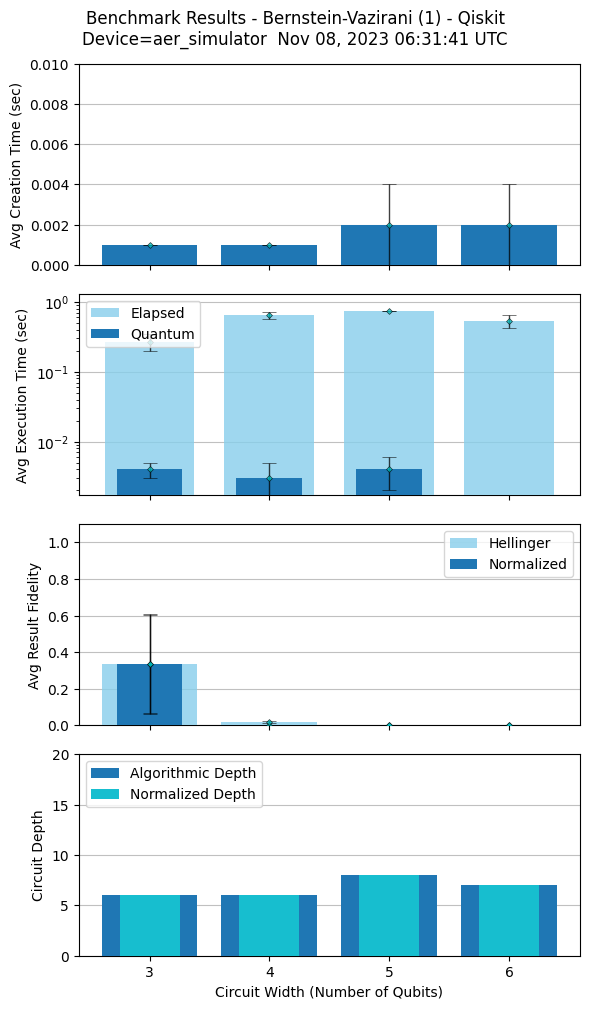

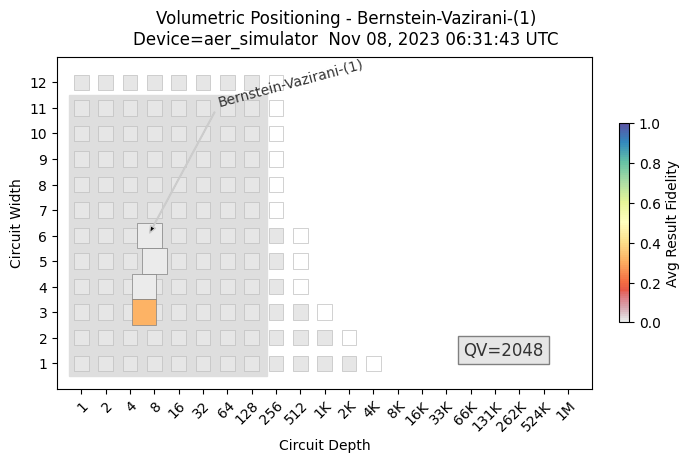

In [10]:
# Execute program with default parameters
def run (min_qubits=3, max_qubits=6, skip_qubits=1, max_circuits=3, num_shots=100,
        backend_id='aer_simulator', method = 1, provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")

    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Variable for new qubit group ordering if using mid_circuit measurements
    mid_circuit_qubit_group = []

    # If using mid_circuit measurements, set transform qubit group to true
    transform_qubit_group = True if method ==2 else False
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    # for noiseless simulation, set noise model to be None
    # ex.set_noise_model(None)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
    
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2**(input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(input_size) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(input_size), num_circuits, False)

        # loop over limited # of secret strings for this
        for s_int in s_range:
            # If mid circuit, then add 2 to new qubit group since the circuit only uses 2 qubits
            if method == 2:
                mid_circuit_qubit_group.append(2)

            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = BersteinVazirani(num_qubits, s_int, method)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)

            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, s_int, shots=num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
        
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method == 1: print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit",
                         transform_qubit_group = transform_qubit_group, new_qubit_group = mid_circuit_qubit_group)
if __name__ == '__main__': run()